# Pingpongball intuition
Here we will model dropping a pingpong ball and create a diffeq that governs its position as a function of time. The trick to this problem is to first think through the physical system, draw out what we think the posiition should look like, what the velocity should look like, and finally what the acceleration should look like. Once we have done these steps, the model of this unfamiliar problem should become clearer.

In [131]:
import matplotlib.pyplot as plt
import numpy as np
from math import e

# Easy problem
It is reasonable to assume that the pingpong ball bounce has two steps. The first is the drop, and the second is the bounce. The drop is much easier to model than the drop, so let us start with that. We will model the position using the classic movement formulas from physics, then take the derivative to see the velocity and accelerations

<img src="out.png" width="150" height=" 150">

In [423]:
# Useful functions
def gravity(t, v0, x0):
    t = np.array(t)
    return( -1/2 * 9.8 * t**2 + v0*t + x0)

def time_to_impact(v0, x0):
    sol1 = (-v0 + np.sqrt(v0**2 + 4*(9.8/2)*x0)) / -9.8
    sol2 = (-v0 - np.sqrt(v0**2 + 4*(9.8/2)*x0)) / -9.8
    return( np.maximum(sol1, sol2) )

In [424]:
x = np.linspace(start = 0, stop = time_to_impact(0, 10), num = 100)
y = gravity(x, 0, 10)
dydt = np.gradient(y,x)
d2ydt2 = np.gradient(dydt,x)

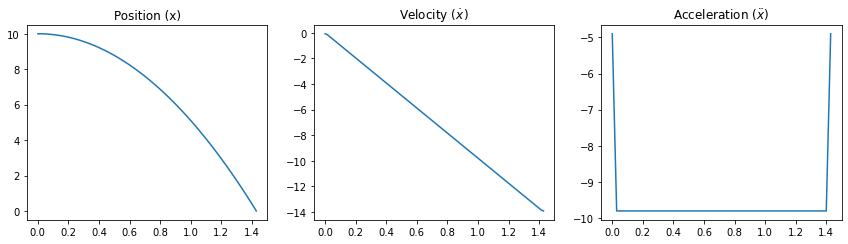

In [430]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))
axes[0].plot(x,y)
axes[0].set_title('Position (x)')
axes[1].plot(x,dydt)
axes[1].set_title(r'Velocity ($\dot x$)')
axes[2].plot(x,d2ydt2)
axes[2].set_title(r'Acceleration ($\ddot x$)')
fig.tight_layout()
plt.show()

# Ideal behavior
Okay, now that we have the drop, what would the bounce look like? I imagine the ball falling under gravity, then at the moment of impact all its downward acceleration suddenly reverses and at the same speed it fell down it would rise. So it is not unreasonable to model the drop, reverse it, and stitch it on the end. The derivates we can reason out, but lets leave it a mystery and see what they look like first!

In [431]:
x0 = 9.8/2
x = np.linspace(start = 0, stop = time_to_impact(0, x0)*2, num = 100)
y = np.concatenate( (gravity(x[0:50], 0, x0), gravity(np.flip(x[0:50]), 0, x0)) )
dydt = np.gradient(y, x)
d2ydt2 = np.gradient(dydt, x)

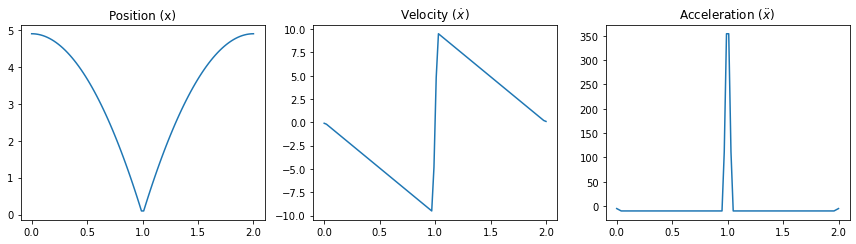

In [435]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

titles = ['Position (x)', r'Velocity ($\dot x$)', r'Acceleration ($\ddot x$)']
for i in range(3):
    axes[i].set_title(titles[i])

axes[0].plot(x,y)
axes[1].plot(x,dydt)
axes[2].plot(x,d2ydt2)
# axes[2].set_ylim([-10.5, -8])
fig.tight_layout()
plt.show()

# Final bounce model
Okay, the previous results are very very interesting; especially the velocity and acceleration. Probably the most important part of this is that the acceleration we have modeled implies the type of schematic we should draw.

<img src="out2.png" width="200" height=" 200">

This schematic is very similar to our original model, except we have added a second force to model the needle spike in acceleration. This second force may look scary, but it isn't too bad. I have called it $F_{imp}$ short hand for impact. That partial derivative symbol is a delta, and it is actually a function called the *Dirac Delta* function. This is a neat function that is the combination of two *Heaviside* functions to produce an impulse, where every value other than $t = t_{imp}$ (short for time of impact) is zero. Multiplying some force F0 by this delta function results in this force being zero everywhere but that point of impact. Taken together, this new model would faithfully recreate the needle spike we see in the above graphs. 


## Setting up and solving the pingpongball diffeq
We have drawn our diagram, now lets set up our equation using physics. Sum of the forces on the object equals its accelration times mass.
$$\sum F = F_{imp} - F_g = m\ddot x$$

Our forces are $F_g = mg$ and $F_{imp} = F_0\delta (t - t_{imp})$ so 
$$F_0\delta (t - t_{imp}) - mg = m\ddot x$$

That's it! That is our diffeq...looks kinda hard huh. Not to worry! We can solve it using the **Laplace transform**! I'm not going to go into the details of the laplace transform, but here we can just use a table and do the forward and backward transforms.

<img src="Lap_table_small.png" width="100" height=" 100">

$$\mathcal{L}(m\ddot x) = \mathcal{L}(F_0\delta (t - t_{imp}) - mg)$$

The laplace transform can distribute to every term and is a linear function so coefficients are retained. Using the table, we can see where $\ddot x$ is, where $\delta$ is, and where coefficients are. So lets apply it to each of our terms. Our answer in S-space will be $\chi$, so we will isolate that to one side.

1. $\mathcal{L}( m\ddot x ) = m(s^2\chi - sx(0) - \dot x(0)$
1. $\mathcal{L}( F_0\delta (t - t_{imp}) ) = F_0e^{-t_{imp}s}$
1. $\mathcal{L}( -mg ) = -\frac{mg}{s}$

$$m(s^2\chi - sx(0) - \dot x(0) = F_0e^{-t_{imp}s} -\frac{mg}{s}$$

Simplifying this gives us our solution in S-space.
$$\chi = \frac{e^{-cs}}{ms^2} - \frac{g}{s^3} + \frac{\dot x(0)}{s^2} + \frac{x(0)}{s}$$

Now the hard part is doing the inverse laplace transform on both sides to solve for our solution in T-space. Looking at the table we can see that the last term is easy, the 1/s becomes a 1. The initial velocity term is also easy, we can see that the 1/s^2 becomes just a t term. etc etc. the hardest part is the exponential, but if we look closely it looks like a heaviside step function multiplying another function! Solving this out gives us.

$$x(t) = \frac{1}{m}H_{t_{imp}}(t) (t-timp) F_0 - \frac{g}{2}t^2 + \dot x(0)t + x(0)$$

In theory, this equation will model a single pingpong ball bounce. Lets implement it and see if it does!

In [475]:
def H(t,tactive):
    return(np.array(t >= tactive, dtype = int))

def pingpongball(t, m=1, v0=0, x0=9.8/2, g = 9.8, bounce_coef = 1, F0 = None):
    def time_to_impact(g, v0, x0):
        sol1 = (-v0 + np.sqrt(v0**2 + 4*(g/2)*x0)) / -g
        sol2 = (-v0 - np.sqrt(v0**2 + 4*(g/2)*x0)) / -g
        return( np.maximum(sol1, sol2) )
    t = np.array(t)
    timp = time_to_impact(g, v0, x0)
    if(F0 is None):
        F0 = bounce_coef * np.sum(m*g*timp) * 2
    return( 1/m * H(t, timp) * (t-timp)*F0 - g/2*t**2 + v0*t + x0 )

In [476]:
x0 = 9.8/2
x = np.linspace(start = 0, stop = 2, num = 500)
y = pingpongball(x, bounce_coef=1)
dydt = np.gradient(y, x)
d2ydt2 = np.gradient(dydt, x)

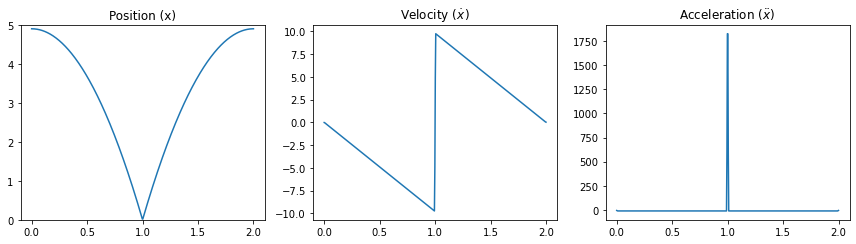

In [477]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

titles = ['Position (x)', r'Velocity ($\dot x$)', r'Acceleration ($\ddot x$)']
for i in range(3):
    axes[i].set_title(titles[i])

axes[0].plot(x,y)
axes[0].set_ylim([0,5])
axes[1].plot(x,dydt)
axes[2].plot(x,d2ydt2)
# axes[2].set_ylim([-10.5, -8])
fig.tight_layout()
plt.show()

## Playing around with model
We can eaven make a custom bounce by setting the `bounce_coef`. For example, if only 70% of the force was hitting the ground was retained, then this is what the bounces would look like.

In [478]:
x0 = 9.8/2
x = np.linspace(start = 0, stop = 2, num = 500)
y = pingpongball(x, bounce_coef=0.7)
dydt = np.gradient(y, x)
d2ydt2 = np.gradient(dydt, x)

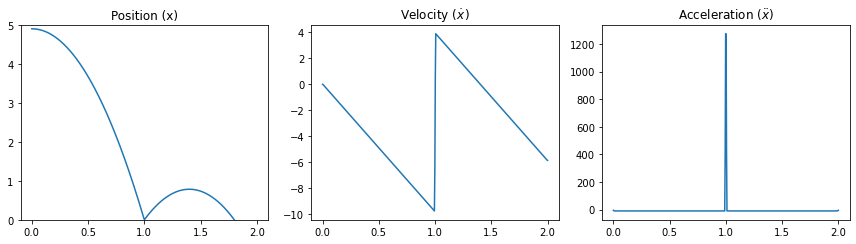

In [479]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5))

titles = ['Position (x)', r'Velocity ($\dot x$)', r'Acceleration ($\ddot x$)']
for i in range(3):
    axes[i].set_title(titles[i])

axes[0].plot(x,y)
axes[0].set_ylim([0,5])
axes[1].plot(x,dydt)
axes[2].plot(x,d2ydt2)
# axes[2].set_ylim([-10.5, -8])
fig.tight_layout()
plt.show()